In [2]:

import pandas as pd 
import os 
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from scipy.stats import mannwhitneyu, normaltest
# import statsmodels.stats.multitest as sm
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test



C:\Users\jhroe\AppData\Local\Temp\ipykernel_24524\3591221630.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# date = datetime.now().strftime("%Y%m%d")

# Get current directory
path = os.getcwd()
data_path = path + '/Data/'

pi = pd.read_excel(f'{data_path}/raw/LUAD Clinical Data.xlsx')

# Set path 
df = pd.read_csv(f"{data_path}/clustering/full_cd_clus_19_39_48.csv").rename(columns={'cluster': 'agglomerateto_275'}).rename(columns={'agglomerateto_39':'cluster'})
df_loc = pd.read_csv(f"{data_path}/celldata/celldata_20240506.csv")[['cellID', 'Location_Center_X', 'Location_Center_Y']].rename(columns={'cellID': 'source_ID'})

# Merge location data 
df_full= pd.merge(df, df_loc, on='source_ID', how='inner').rename(columns={'agglomerateto_39':'cluster'})


In [4]:
data = df[['Patient_ID', 'cluster']]
count_data = data.groupby(['Patient_ID', 'cluster']).size().reset_index(name='count')
total_clus = count_data.groupby(['Patient_ID'])['count'].sum().reset_index(name='total_clus')
count_df = pd.merge(count_data, total_clus, on=['Patient_ID'])

count_df['relative_frequency'] = (count_df['count'] / count_df['total_clus'])
count_df
# count_data

,Patient_ID,cluster,count,total_clus,relative_frequency
0,LUAD_D001,1,56,4517,0.012398
1,LUAD_D001,2,3,4517,0.000664
2,LUAD_D001,3,12,4517,0.002657
3,LUAD_D001,4,198,4517,0.043834
4,LUAD_D001,5,1378,4517,0.305070
...,...,...,...,...,...
12877,LUAD_D416,35,11,2879,0.003821
12878,LUAD_D416,36,7,2879,0.002431
12879,LUAD_D416,37,13,2879,0.004515
12880,LUAD_D416,38,10,2879,0.003473


In [5]:
pi.rename(columns={'Key':'Patient_ID', 'Survival or loss to follow-up (years)':'survival', 'Death (No: 0, Yes: 1)':'death'}, inplace=True)

df_full = pd.merge(count_df, pi, on='Patient_ID', how='inner')
df_full[df_full['cluster']==1]

,Patient_ID,cluster,count,total_clus,relative_frequency,"Sex (Male: 0, Female: 1)","Age (<75: 0, ≥75: 1)","BMI (<30: 0, ≥30: 1)","Smoking Status (Smoker: 0, Non-smoker:1)","Pack Years (1-30: 0, ≥30: 1)","Stage (I-II: 0, III-IV:1)","Progression (No: 0, Yes: 1)",death,survival,"Predominant histological pattern (Lepidic:1, Papillary: 2, Acinar: 3, Micropapillary: 4, Solid: 5)"
0,LUAD_D001,1,56,4517,0.012398,0,0,1,0.0,1.0,0.0,0.0,1,8.386,3
34,LUAD_D002,1,60,3121,0.019225,0,0,0,0.0,1.0,0.0,1.0,0,10.111,1
64,LUAD_D003,1,27,3338,0.008089,0,0,0,0.0,1.0,0.0,0.0,1,2.094,5
101,LUAD_D004,1,85,4237,0.020061,0,1,0,0.0,1.0,0.0,0.0,1,1.755,4
130,LUAD_D005,1,33,4300,0.007674,1,0,1,0.0,1.0,0.0,0.0,1,7.598,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12715,LUAD_D412,1,123,4522,0.027200,1,0,1,0.0,0.0,0.0,0.0,0,9.944,3
12747,LUAD_D413,1,202,4480,0.045089,1,0,0,0.0,0.0,0.0,0.0,0,8.132,1
12778,LUAD_D414,1,95,5561,0.017083,1,0,0,0.0,1.0,0.0,0.0,0,8.550,3
12812,LUAD_D415,1,125,2913,0.042911,1,0,0,0.0,1.0,0.0,0.0,1,1.862,3


In [6]:
relevant = df_full[['Patient_ID', 'cluster', 'survival', 'death', 'relative_frequency']]
relevant[relevant['Patient_ID'] == 'LUAD_D001']
# relevant

,Patient_ID,cluster,survival,death,relative_frequency
0,LUAD_D001,1,8.386,1,0.012398
1,LUAD_D001,2,8.386,1,0.000664
2,LUAD_D001,3,8.386,1,0.002657
3,LUAD_D001,4,8.386,1,0.043834
4,LUAD_D001,5,8.386,1,0.305070
5,LUAD_D001,6,8.386,1,0.017932
6,LUAD_D001,7,8.386,1,0.077706
7,LUAD_D001,8,8.386,1,0.015940
8,LUAD_D001,9,8.386,1,0.016604
9,LUAD_D001,11,8.386,1,0.012840


In [7]:
patients_with_neg_zscore

NameError: name 'patients_with_neg_zscore' is not defined

Amount of people with 0 prevalence exactly: 0


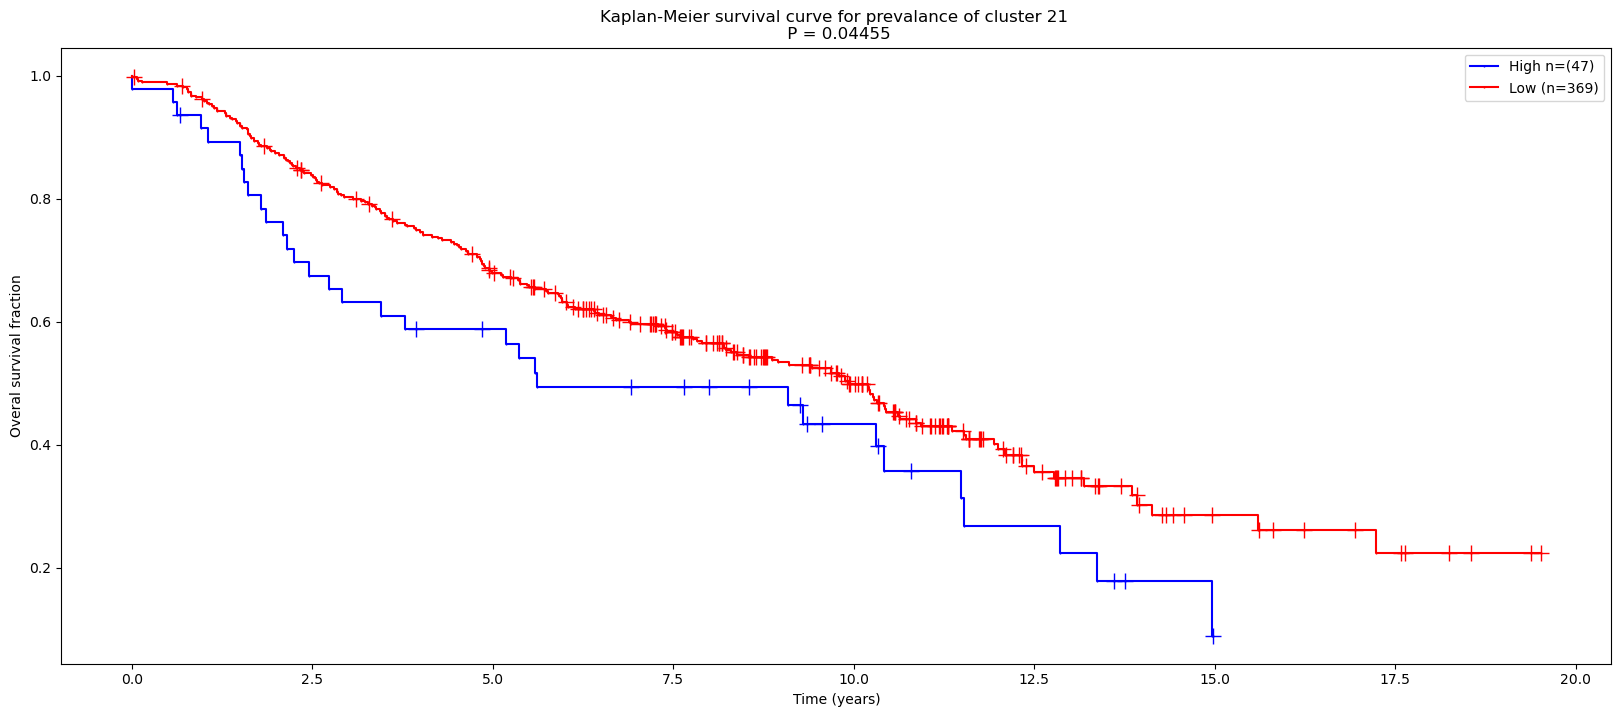

In [9]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 21

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# Log rank test 
p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 8))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster} \n P = {round(p_val, 5)}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.show()

Amount of people with 0 prevalence exactly: 0


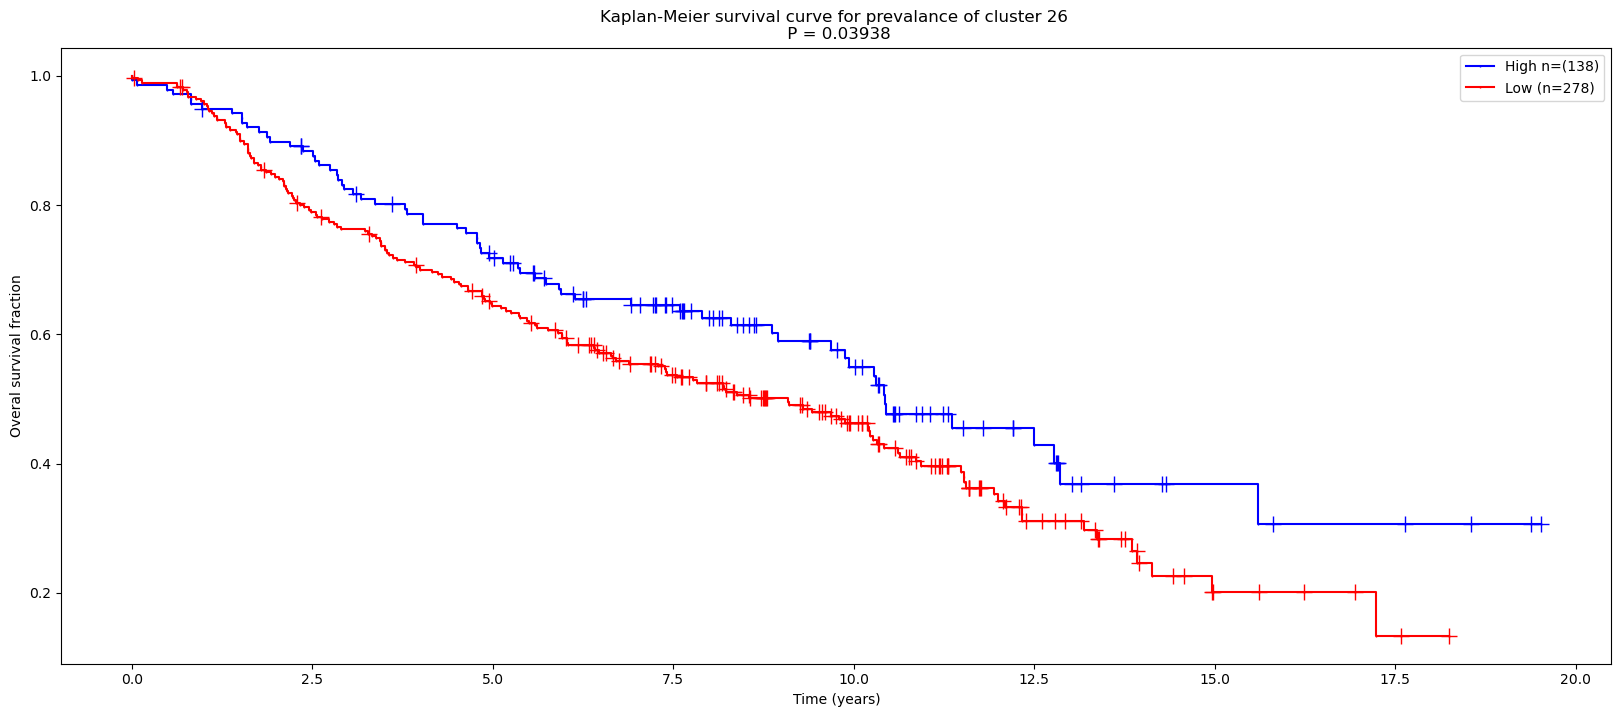

In [ ]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 26

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# Log rank test 
p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 10))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()

plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster} \n P = {round(p_val, 5)}')
plt.xlabel('Time (years)')
plt.ylabel('Overal survival fraction')
plt.show()

In [ ]:

# kaplan meijer plot accoring to Sorin

# Insert cluster for which kaplan meijer needs to be divided
vip_cluster = 26

patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
patients_km.fillna(0, inplace=True)

# Calculate the z-score for the 'agglomerateto40' column
patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
patients_km.reset_index('survival', inplace=True)

# Sort the DataFrame by survival years in ascending order
df_sorted_km = patients_km.sort_values(by='survival')

# Filter the dataframe for patients with a z-score of 0 or higher
patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

print("Amount of people with 0 prevalence exactly:",len(df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] == 0]))

# Log rank test 
p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

# --------
# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier curve to your data
kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])

# Plot the first curve
plt.figure(figsize=(20, 8))
kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=1)


kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=1)

# Plot the Kaplan-Meier curve
# kmf.plot_survival_function()
plt.title(f'Kaplan-Meier survival curve for prevalance of cluster {vip_cluster} \n P = {round(p_val, 5)}')


In [38]:
ax[7][2]

<Axes: >

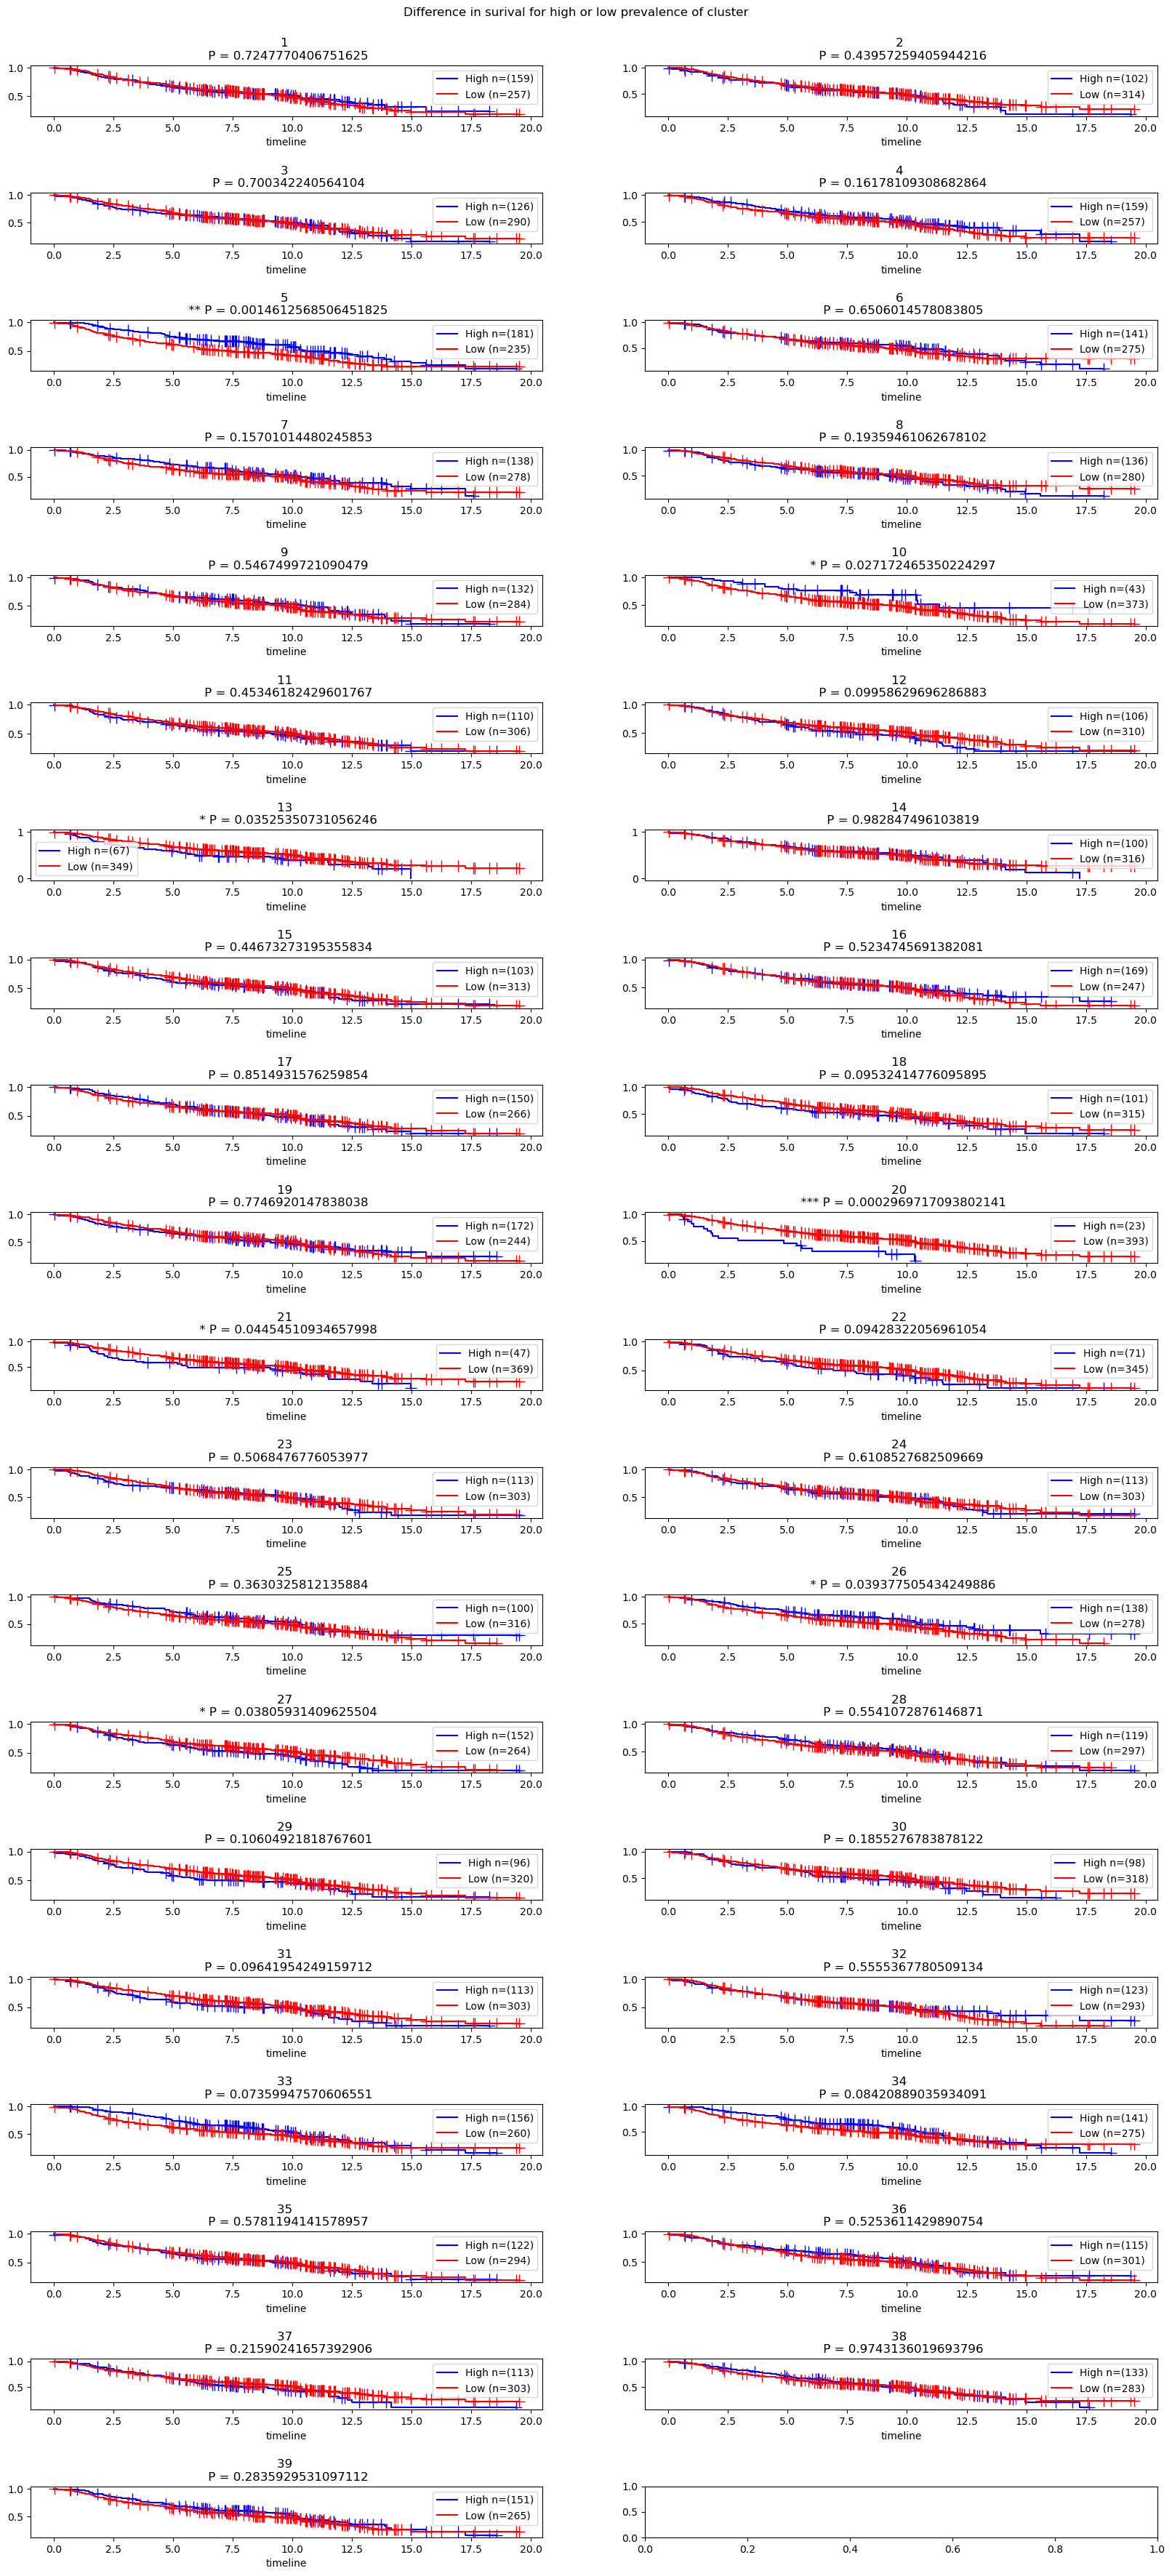

In [11]:
# Create subplots
fig, ax = plt.subplots(20, 2, figsize=(20, 40))
plt.subplots_adjust(hspace=1.5)  # Adjust vertical space between subplots


for vip_cluster in range(1, df_full['cluster'].max() + 1):


    patients_km = df_full.pivot(columns='cluster', index=['Patient_ID', 'survival', 'death'], values='relative_frequency')
    patients_km.fillna(0, inplace=True)

    # Calculate the z-score for the 'agglomerateto40' column
    patients_km[f'zscore_c{vip_cluster}'] = stats.zscore(patients_km[[vip_cluster]])
    patients_km.reset_index('survival', inplace=True)

    # Sort the DataFrame by survival years in ascending order
    df_sorted_km = patients_km.sort_values(by='survival')

    # Filter the dataframe for patients with a z-score of 0 or higher
    patients_with_neg_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] < 0].reset_index('death')
    patients_with_pos_zscore = df_sorted_km[df_sorted_km[f'zscore_c{vip_cluster}'] > 0].reset_index('death')

    p_val = logrank_test(patients_with_pos_zscore['survival'], patients_with_neg_zscore['survival'], event_observed_A=patients_with_pos_zscore['death'], event_observed_B=patients_with_neg_zscore['death']).p_value

    # Create a KaplanMeierFitter object
    kmf = KaplanMeierFitter()

    # Fit the Kaplan-Meier curve to your data
    kmf.fit(durations=patients_with_pos_zscore['survival'], event_observed=patients_with_pos_zscore['death'])
    # Plot the first curve
    kmf.plot(label=f'High n=({len(patients_with_pos_zscore)})', color='blue', ci_show=False, show_censors=True, marker='|', markersize=0.01, ax=ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2])

    kmf.fit(durations=patients_with_neg_zscore['survival'], event_observed=patients_with_neg_zscore['death'])
    kmf.plot(label=f'Low (n={len(patients_with_neg_zscore)})', color='red', ci_show=False, show_censors=True, marker='|', markersize=0.01, ax=ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2])
    
    if p_val < 0.001:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n *** P = {p_val}')
    elif p_val < 0.01:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n ** P = {p_val}')
    elif p_val < 0.05:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n * P = {p_val}')
    else:
        ax[(vip_cluster - 1)//2][(vip_cluster - 1)%2].set_title(f'{vip_cluster} \n P = {p_val}')


    

fig.suptitle(f'Difference in surival for high or low prevalence of cluster')
plt.subplots_adjust(top=0.96)  # Adjust the top to make room for the title

plt.show()
    # print(vip_cluster, (vip_cluster - 1)//4,(vip_cluster - 1)% )
    # kmf.plot()
    # ax[(vip_cluster - 1)//4][(vip_cluster - 1)%4].set_title(f'Differenc in surival for high or low prevalence of cluster {vip_cluster}')
    # plt.legend(None)



